In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# import data
data = pd.read_csv('covid19.csv')
data = data.drop(["prnameFR","pruid","numprob","numtotal","percentrecover",
                  "percentoday", "numtested","ratedeaths","ratetested", "ratetotal",
                  "percentdeath","numtestedtoday","percentactive","numdeathstoday",
                  "numrecoveredtoday","rateactive","numtotal_last14","ratetotal_last14",
                  "numdeaths_last14","ratedeaths_last14","numtoday","numactive"],axis =1)
data = data.rename(columns={"prname":"province","numconf": "confirmed", "numdeaths": "deaths", "numrecover": "recover"})
data = data.drop(data[data["province"] == 'Repatriated travellers'].index).reset_index(drop = True)
data = data.replace(np.nan, 0, regex = True)
data["active"] = data["confirmed"] - data["recover"] - data["deaths"]
data['date'] = pd.to_datetime(data['date'],format='%d-%m-%Y')
data[['confirmed']] = data[["confirmed"]].astype(float)
    

## Population

In [4]:
population_data = pd.read_csv("ca_population.csv",thousands=',')
population_data = population_data.drop(["Q2 2019","Q3 2019","Q4 2019","Q1 2020"],axis=1)
population_data = population_data.rename(columns={"Q2 2020":"population","Geography":"province"})
population_data = population_data[["province","population"]]
population_data.index = population_data["province"]
population_data[["population"]] = population_data[["population"]].astype(float)
population_data = population_data.drop(['province'],axis=1)
population_data

,population
province,
Canada,37971020.0
Newfoundland and Labrador,520437.0
Prince Edward Island,158717.0
Nova Scotia,978274.0
New Brunswick,780890.0
Quebec,8552362.0
Ontario,14745040.0
Manitoba,1379121.0
Saskatchewan,1181987.0


In [5]:
train_df = data.merge(population_data, how="left", on=['province']).drop_duplicates()
train_df["population"] = train_df['population']- train_df["deaths"]
train_df["suscepitable"] = train_df['population']-train_df["confirmed"] - train_df["recover"]
train_df.head()

,province,date,confirmed,deaths,recover,active,population,suscepitable
0,Ontario,2020-01-31,3.0,0.0,0.0,3.0,14745040.0,14745037.0
1,British Columbia,2020-01-31,1.0,0.0,0.0,1.0,5120184.0,5120183.0
2,Canada,2020-01-31,4.0,0.0,0.0,4.0,37971020.0,37971016.0
3,Ontario,2020-02-08,3.0,0.0,0.0,3.0,14745040.0,14745037.0
4,British Columbia,2020-02-08,4.0,0.0,0.0,4.0,5120184.0,5120180.0


## Mobility

In [6]:
# mobility
from sklearn import preprocessing
mobility = pd.read_csv("Global_Mobility_Report.csv")
mobility = mobility.query("country_region_code == 'CA' ")
mobility = mobility.drop(['country_region_code','country_region', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'country_region_code'],axis =1).reset_index(drop = True)
mobility = mobility.rename(columns={"sub_region_1":"province",
                         "retail_and_recreation_percent_change_from_baseline": "retail", 
                         "grocery_and_pharmacy_percent_change_from_baseline": "grocery", 
                         "parks_percent_change_from_baseline": "park", 
                         "transit_stations_percent_change_from_baseline": "transit",
                         "workplaces_percent_change_from_baseline": "workplaces",
                         "residential_percent_change_from_baseline": "residential"})
mobility = mobility.fillna({'province':'Canada','retail':0, 'grocery':0, 'park':0 , 'transit':0, 'workplaces':0, 'residential':0})

mobility['date'] = pd.to_datetime(mobility['date'],format='%Y-%m-%d')

# normalization
cols = ['retail', 'grocery', 'park', 'transit', 'workplaces']
scaler = preprocessing.StandardScaler()
scaler.fit(mobility[cols])
mobility[cols] = scaler.transform(mobility[cols])
scaler = preprocessing.StandardScaler()
mobility['mobility_cof'] = np.mean(mobility[cols].values, axis=1)
_=mobility['mobility_cof'].values
mobility['mobility_cof'] = scaler.fit_transform(_.reshape(_.shape[0],1))
mobility = mobility.drop(['retail', 'grocery', 'park', 'transit', 'workplaces','residential'],axis=1)
del _
del cols

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:


train_df = train_df.merge(mobility, how="left", on=['province','date']).drop_duplicates()
train_df = train_df.replace(np.nan, 0)
_t = train_df["mobility_cof"].values 
train_df['mobility_cof'] = np.append(_t[14:],_t[:14])
train_df

,province,date,confirmed,deaths,recover,active,population,suscepitable,mobility_cof
0,Ontario,2020-01-31,3.0,0.0,0.0,3.0,14745040.0,14745037.0,1.001177
1,British Columbia,2020-01-31,1.0,0.0,0.0,1.0,5120184.0,5120183.0,1.027888
2,Canada,2020-01-31,4.0,0.0,0.0,4.0,37971020.0,37971016.0,1.054899
3,Ontario,2020-02-08,3.0,0.0,0.0,3.0,14745040.0,14745037.0,1.018283
4,British Columbia,2020-02-08,4.0,0.0,0.0,4.0,5120184.0,5120180.0,0.502498
...,...,...,...,...,...,...,...,...,...
2138,Prince Edward Island,2020-08-06,36.0,0.0,36.0,0.0,158717.0,158645.0,0.730928
2139,Yukon,2020-08-06,14.0,0.0,13.0,1.0,41293.0,41266.0,1.161877
2140,Northwest Territories,2020-08-06,5.0,0.0,5.0,0.0,0.0,0.0,0.826453
2141,Nunavut,2020-08-06,0.0,0.0,0.0,0.0,0.0,0.0,0.962369


## Preprocess

In [8]:
from datetime import timedelta
from datetime import datetime

def subset(dataset,province,start,end):
    str_start = datetime.strptime(start, "%Y-%m-%d")
    str_end = datetime.strptime(end, "%Y-%m-%d")
    sub = dataset.query(f"province=='{province}' and date>='{str_start}' and date<= '{str_end}'")
    return sub.reset_index(drop=True).drop(["province"], axis = 1)

# province-wise
Canada = subset(train_df,"Canada","2020-03-10","2020-06-30")
Ontario = subset(train_df,"Ontario","2020-03-10","2020-06-30")
BC = subset(train_df,"British Columbia","2020-03-10","2020-06-30")
Quebec = subset(train_df,"Quebec","2020-03-10","2020-06-30")
Alberta = subset(train_df,"Alberta","2020-03-10","2020-06-30")

provinces = [Canada, Ontario, BC, Quebec, Alberta]

In [9]:
def preprocess(province, trained_scaler=None):
    
    cases_data = province[['confirmed','deaths']].values
    
    if trained_scaler:
        scaler = trained_scaler
        after = scaler.transform(cases_data)
    else:
        scaler = preprocessing.StandardScaler()
        after = scaler.fit_transform(cases_data)

    province['confirmed'] = after[:,0]
    province['deaths'] = after[:,1]
    return scaler

In [10]:
def de_scale(trained_scaler,m,n):
    m=m.reshape(len(m),1)
    n=n.reshape(len(n),1)
    x=trained_scaler.inverse_transform(np.append(m,n,axis=1))
    return x[:,0],x[:,1]

In [11]:
# preprocess all data 
scaler_list = []
for p in range(len(provinces)):
    scaler=preprocess(provinces[p])
    scaler_list.append(scaler)

## Create LSTM input

In [12]:
def LSTM_input(province, days_in_sequence = 14, mobility = False, shuffle=True):

    trend_df = pd.DataFrame(columns={"infection_trend","death_trend", "mobility_trend",
                                     "expected_cases","expected_deaths"})
    trend_list = []
    

    for i in range(len(province)):
        if i+days_in_sequence<len(province):
            infection_trend = [float(x) for x in province[i:i+days_in_sequence].confirmed.values]
            death_trend = [float(x) for x in province[i:i+days_in_sequence].deaths.values]
            mobility_trend = [float(x) for x in province[i:i+days_in_sequence].mobility_cof.values]
            expected_cases = float(province.iloc[i+days_in_sequence].confirmed)
            expected_deaths = float(province.iloc[i+days_in_sequence].deaths)
            trend_list.append({
                "infection_trend": infection_trend,
                "death_trend": death_trend,
                "mobility_trend": mobility_trend,
                "expected_cases": expected_cases,
                "expected_deaths":expected_deaths,
            })
    trend_df=pd.DataFrame(trend_list)
    trend_df['inputs'] = [np.asarray([trends["infection_trend"],trends["death_trend"]]) 
                      for idx,trends in trend_df.iterrows()]
    if mobility:
        trend_df['inputs'] = [np.asarray([trends["infection_trend"],trends["death_trend"],trends["mobility_trend"]]) 
                      for idx,trends in trend_df.iterrows()]
    else:
        trend_df['inputs'] = [np.asarray([trends["infection_trend"],trends["death_trend"]]) 
                      for idx,trends in trend_df.iterrows()]
    if shuffle:
        trend_df = sklearn.utils.shuffle(trend_df)
    return trend_df

In [13]:
sequence_length = 14
input_list = []
# input without mobility
for p in range(len(provinces)):
    province_df = LSTM_input(provinces[p], sequence_length, mobility = False, shuffle=True)
    input_list.append(province_df)
    


In [14]:
def resample(df):
    
    sequence_length = df.inputs[0].shape[1]
    training_percentage = 0.8
    features_num = df.inputs[0].shape[0]
    
    training_item_count = int(len(df)*training_percentage)
    validation_item_count = len(df)-training_item_count
    training_df = df[:training_item_count]
    validation_df = df[training_item_count:]
    
    X_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) 
                        for x in training_df["inputs"].values]),
                        (training_item_count,features_num,sequence_length)),(0,2,1) )).astype(np.float32)
    Y_confirmed_train = np.asarray([np.asarray(x) 
                    for x in training_df["expected_cases"]]).astype(np.float32)
    Y_deaths_train = np.asarray([np.asarray(x) for x in training_df["expected_deaths"]]).astype(np.float32)
    
    X_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) 
                    for x in validation_df["inputs"]]),
                    (validation_item_count,features_num,sequence_length)),(0,2,1)) ).astype(np.float32)
    Y_confirmed_test = np.asarray([np.asarray(x) 
                    for x in validation_df["expected_cases"]]).astype(np.float32)
    Y_deaths_test = np.asarray([np.asarray(x) for x in validation_df["expected_deaths"]]).astype(np.float32)
    
    return (X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test)

In [15]:
province_names = ["Canada", "Ontario", "BC", "Quebec", "Alberta"]
input_list1 = []
for p in range(len(input_list)):
    diction = resample(input_list[p])
    input_list1.append(diction)
    
del input_list

## Build LSTM

In [16]:
from tensorflow.keras import layers
from tensorflow.keras import Input, models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def LSTM_model(name,sequence_length=14, features_num = 2):

    # input layer branch
    input_layer = Input(shape=(sequence_length,features_num))
    main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.01, activation='relu')(input_layer)


    #cases output branch
    rnn_c = layers.LSTM(32, activation='relu')(main_rnn_layer)
    dense_c = layers.Dense(128, activation='relu')(rnn_c)
    dropout_c = layers.Dropout(0.3)(dense_c)
    dense_c2 = layers.Dense(128, activation='relu')(dropout_c)
    dropout_c2 = layers.Dropout(0.3)(dense_c2)
    cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c2)

    #death output branch
    rnn_d = layers.LSTM(32, activation='relu')(main_rnn_layer)
    dense_d = layers.Dense(128, activation='relu')(rnn_d)
    dropout_d = layers.Dropout(0.3)(dense_d)
    dense_d2 = layers.Dense(128, activation='relu')(dropout_d)
    dropout_d2 = layers.Dropout(0.3)(dense_d2)
    deaths = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="deaths")(dropout_d2)


    model = Model([input_layer], [cases,deaths])

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath=name+'_LSTM_best.h5', monitor='val_loss', save_best_only=True)]

    model.compile(loss=["mse","mse"], optimizer="adam")

    return model, callbacks



In [17]:
histories = []
for p in range(len(province_names)):
    LSTM, LSTM_callbacks = LSTM_model(province_names[p])
    X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test = input_list1[p]
    
    history = LSTM.fit([X_train], [Y_confirmed_train, Y_deaths_train],
                       epochs = 20, batch_size = 10, verbose=0,
                       validation_data=([X_test],[Y_confirmed_test, Y_deaths_test]),
                       callbacks= LSTM_callbacks)
    LSTM.fit
    histories.append(history)


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.


## Training Performance

In [18]:
import matplotlib.pyplot as plt

# the function to plot loss vs epochs
def plot_loss(title, history):
    names = [title+" Confirmed cases Loss over Epochs", title+" Deaths Loss over Epochs"]       
    loss_types = ['cases_loss','deaths_loss', ]
   
    fig, (ax1, ax2) = plt.subplots(1, 2)
    axs = [ax1,ax2]
    
    for i in range(2):
        axs[i].plot(history.history[loss_types[i]], label=loss_types[i])
        axs[i].plot(history.history['val_'+loss_types[i]], label = 'val_'+loss_types[i])
        axs[i].set(xlabel='Epoch', ylabel='Loss',
            title=names[i])
        axs[i].grid()
        axs[i].legend(loc='right')
    fig.set_size_inches(15, 4)
    fig.savefig(names[i]+".png")
    plt.show()

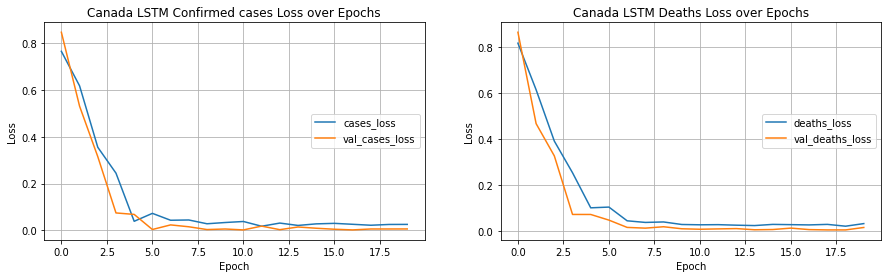

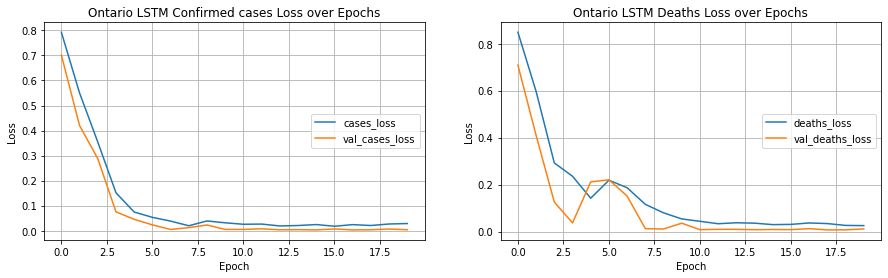

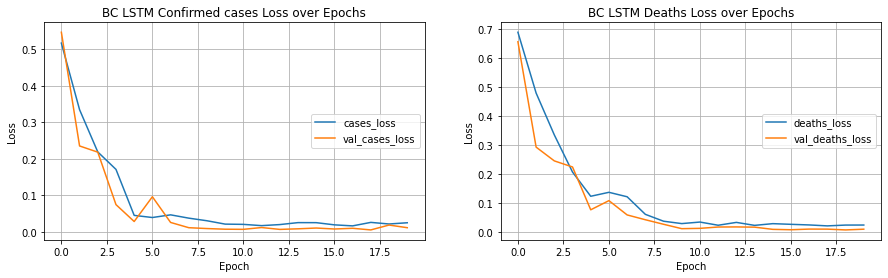

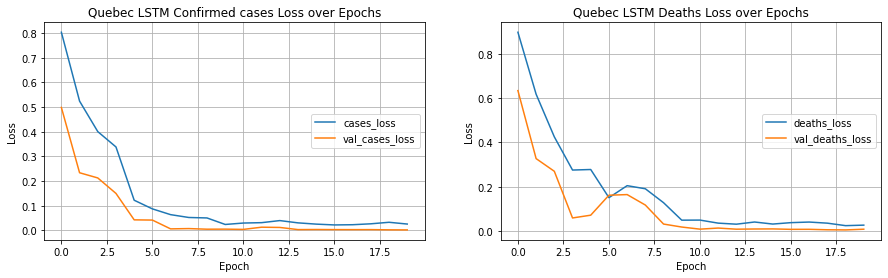

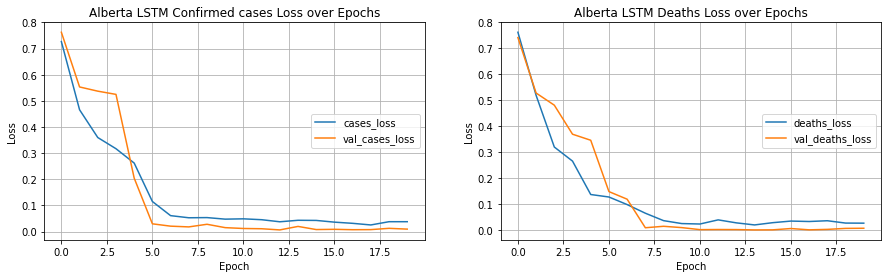

In [19]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_loss(name+" LSTM", histories[p])

## Predictions

In [20]:
from sklearn.metrics import mean_squared_error

def RMSE(truths, predictions):
    confirmed,deaths = predictions
    real_confirmed,real_deaths = truths
    
    confirmed_RMSE = np.sqrt(mean_squared_error(real_confirmed, confirmed))
    deaths_RMSE = np.sqrt(mean_squared_error(real_deaths, deaths))
    
    print("RMSE on test set of Confirmed cases: ",confirmed_RMSE)
    print("RMSE on test set of deaths cases: ",deaths_RMSE)
    
    return

def model_predict(model, model_path, x_pred):
    model.load_weights(model_path)
    predictions = model.predict([x_pred])

    # confirmed, deaths
    return predictions

In [21]:
# Create prediction set
def LSTM_predict_set(df):
    sequence_length = df.inputs[0].shape[1]
    features_num = df.inputs[0].shape[0]
    
    X_pred = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) 
                    for x in df["inputs"].values]),
                    (len(df),features_num,sequence_length)),(0,2,1) )).astype(np.float32)
    Y_confirmed_pred = np.asarray([np.asarray(x) for x in df["expected_cases"]]).astype(np.float32)
    Y_deaths_pred = np.asarray([np.asarray(x) for x in df["expected_deaths"]]).astype(np.float32)
    
    
    return (X_pred, Y_confirmed_pred, Y_deaths_pred)

In [22]:
# test set preprocess
# province-wise
Canada_p = subset(train_df,"Canada","2020-06-17","2020-07-30")
Ontario_p = subset(train_df,"Ontario","2020-06-17","2020-07-30")
BC_p = subset(train_df,"British Columbia","2020-06-17","2020-07-30")
Quebec_p = subset(train_df,"Quebec","2020-06-17","2020-07-30")
Alberta_p = subset(train_df,"Alberta","2020-06-17","2020-07-30")

provinces_p = [Canada_p,Ontario_p,BC_p,Quebec_p,Alberta_p]
label_list=[]
pred_list=[]

# TEST
for p in range(len(province_names)):
    name = province_names[p]
    #s = scaler_list[p]
    scaler2 = preprocess(provinces_p[p])
    provinces_p[p] = LSTM_input(provinces_p[p], shuffle=False)
    
    x_pred, y_confirmed_pred, y_deaths_pred = LSTM_predict_set(provinces_p[p])
    LSTM, LSTM_callbacks = LSTM_model("test")
    pred = model_predict(LSTM, province_names[p]+"_LSTM_best.h5", x_pred)
    print(province_names[p]+":")
    
    confirmed,deaths = de_scale(scaler2,pred[0],pred[1])
    real_confirmed,real_deaths = de_scale(scaler2,y_confirmed_pred,y_deaths_pred)
    
    RMSE([real_confirmed,real_deaths], [confirmed,deaths])

    label_list.append([real_confirmed,real_deaths])
    pred_list.append([confirmed,deaths])

Canada:
RMSE on test set of Confirmed cases:  1643.5667
RMSE on test set of deaths cases:  73.07233
Ontario:
RMSE on test set of Confirmed cases:  567.3504
RMSE on test set of deaths cases:  21.32725
BC:
RMSE on test set of Confirmed cases:  108.0377
RMSE on test set of deaths cases:  4.1422844
Quebec:
RMSE on test set of Confirmed cases:  517.53174
RMSE on test set of deaths cases:  51.118305
Alberta:
RMSE on test set of Confirmed cases:  438.86206
RMSE on test set of deaths cases:  6.308545


In [23]:
import matplotlib.dates as mdates

def plot_prediction(prov_name, y_reals, y_predictions, y_lim=None):

    start = datetime.strptime("2020-07-01", "%Y-%m-%d")
    end = datetime.strptime("2020-07-30", "%Y-%m-%d")
    date_list = [(start + timedelta(x)).date() for x in range(int ((end - start).days)+1)]
    
    name1 = "The actual and predicted number of confirmed cases in {}".format(prov_name)  
    name2 = "The actual and predicted number of deaths in {}".format(prov_name)  
    names =[name1,name2]
    fig, (ax1, ax2) = plt.subplots(1,2)
    axs=[ax1,ax2]
    for i in range(2):
        axs[i].plot(date_list,y_predictions[i], label="Prediction")
        axs[i].plot(date_list,y_reals[i], label = "Groundtruth")
        axs[i].set(xlabel='Date', ylabel='Number of cases',
            title=names[i])
        if y_lim:
            axs[i].set(ylim=y_lim)
        axs[i].grid()
        axs[i].legend(loc='lower right')   
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

    fig.set_size_inches(15, 3)
    fig.savefig(prov_name+" comparison.png")
    plt.show()


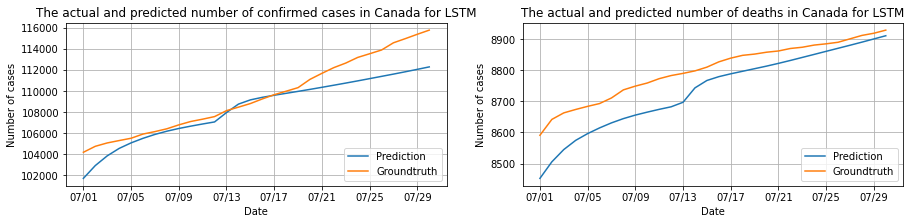

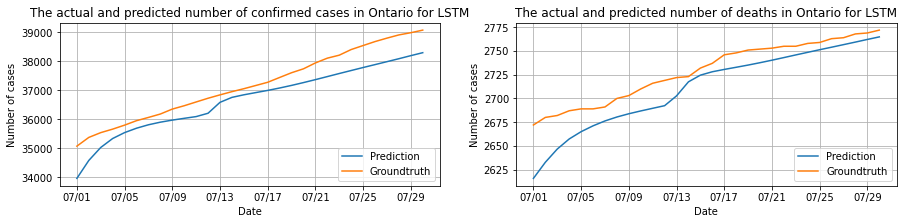

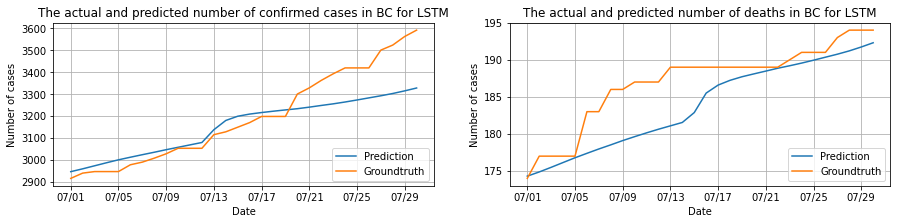

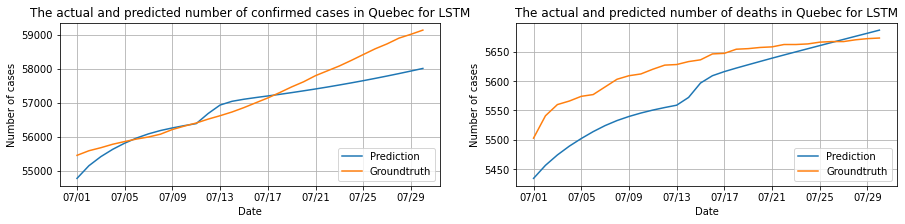

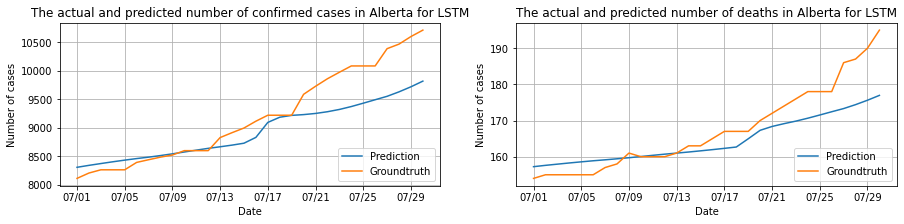

In [24]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_prediction(name+" for LSTM",label_list[p], pred_list[p])

## With immigration

In [25]:
mobility_canada=subset(mobility,"Canada","2020-04-01","2020-06-30")
mobility_canada=mobility_canada[['date','mobility_cof']]
mobility_canada['mobility_cof'].values.shape

(91,)

In [26]:
sequence_length = 14
input_list = []
# input with mobility
for p in range(len(provinces)):
    province_df = LSTM_input(provinces[p], sequence_length, mobility = True, shuffle=True)
    diction = resample(province_df)
    input_list.append(diction)

## Build immigration LSTM model

In [27]:
histories = []

for p in range(len(province_names)):
    LSTM, LSTM_callbacks = LSTM_model(province_names[p]+"_mob", features_num = 3)
    X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test = input_list[p]
    
    history = LSTM.fit([X_train], [Y_confirmed_train, Y_deaths_train],
                       epochs = 20, batch_size = 10, verbose=0,
                       validation_data=([X_test],[Y_confirmed_test, Y_deaths_test]),
                       callbacks= LSTM_callbacks)
    histories.append(history)


Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.


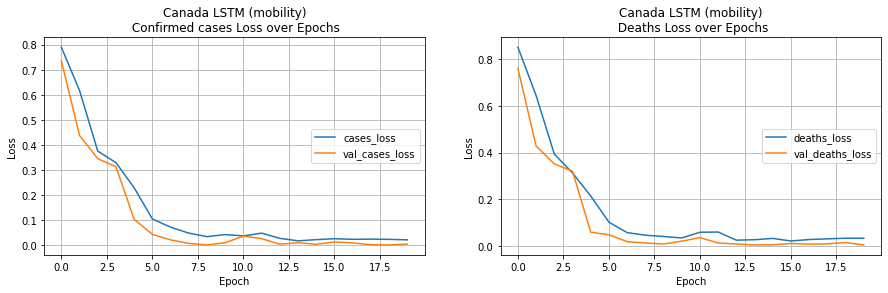

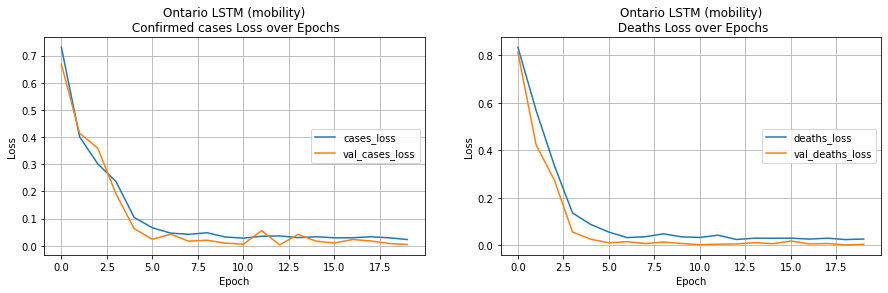

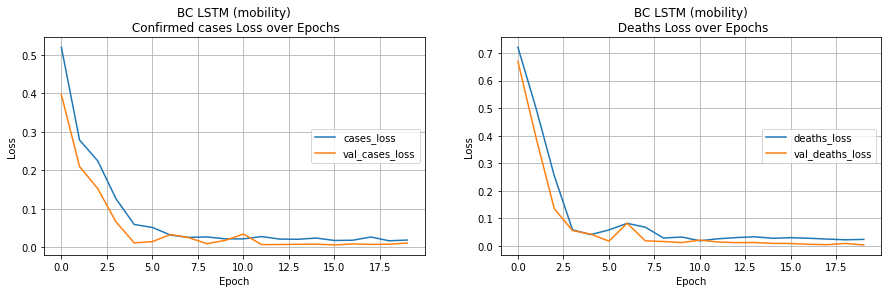

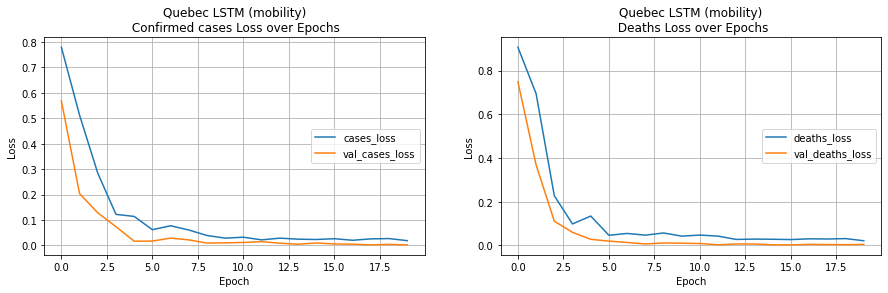

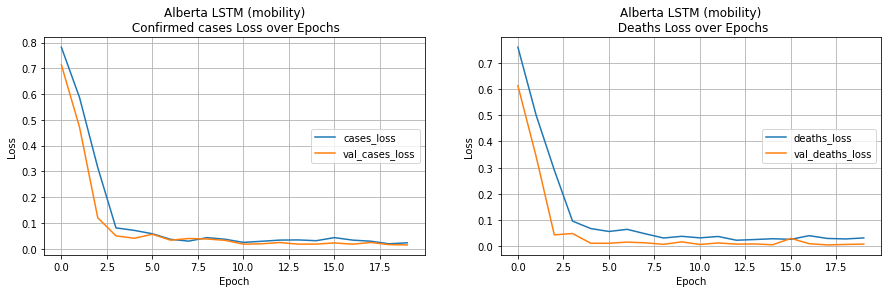

In [28]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_loss(name+" LSTM (mobility)\n", histories[p])

In [29]:
# test set preprocess
# province-wise
Canada_p = subset(train_df,"Canada","2020-06-17","2020-07-30")
Ontario_p = subset(train_df,"Ontario","2020-06-17","2020-07-30")
BC_p = subset(train_df,"British Columbia","2020-06-17","2020-07-30")
Quebec_p = subset(train_df,"Quebec","2020-06-17","2020-07-30")
Alberta_p = subset(train_df,"Alberta","2020-06-17","2020-07-30")

provinces_p = [Canada_p,Ontario_p,BC_p,Quebec_p,Alberta_p]
label_list=[]
pred_list=[]

# TEST
for p in range(len(province_names)):
    name = province_names[p]
    #s = scaler_list[p]
    scaler2 = preprocess(provinces_p[p])
    provinces_p[p] = LSTM_input(provinces_p[p], mobility = True, shuffle=False)
    
    x_pred, y_confirmed_pred, y_deaths_pred = LSTM_predict_set(provinces_p[p])
    LSTM, LSTM_callbacks = LSTM_model("test",features_num = 3)
    pred = model_predict(LSTM, province_names[p]+"_mob_LSTM_best.h5", x_pred)
    print(province_names[p]+":")
    
    confirmed,deaths = de_scale(scaler2,pred[0],pred[1])
    real_confirmed,real_deaths = de_scale(scaler2,y_confirmed_pred,y_deaths_pred)
    
    RMSE([real_confirmed,real_deaths], [confirmed,deaths])

    label_list.append([real_confirmed,real_deaths])
    pred_list.append([confirmed,deaths])

Canada:
RMSE on test set of Confirmed cases:  1736.1853
RMSE on test set of deaths cases:  68.7302
Ontario:
RMSE on test set of Confirmed cases:  625.78644
RMSE on test set of deaths cases:  20.416609
BC:
RMSE on test set of Confirmed cases:  111.4732
RMSE on test set of deaths cases:  4.213763
Quebec:
RMSE on test set of Confirmed cases:  474.24475
RMSE on test set of deaths cases:  37.232384
Alberta:
RMSE on test set of Confirmed cases:  448.57498
RMSE on test set of deaths cases:  7.0885124


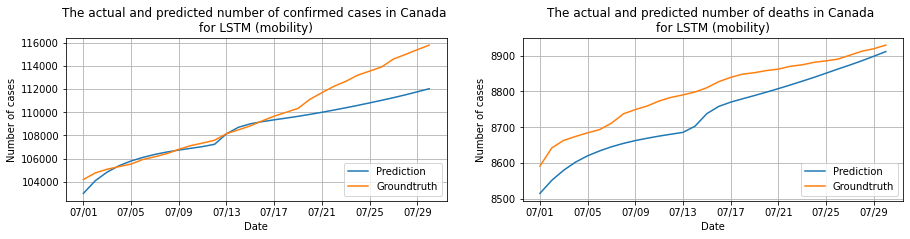

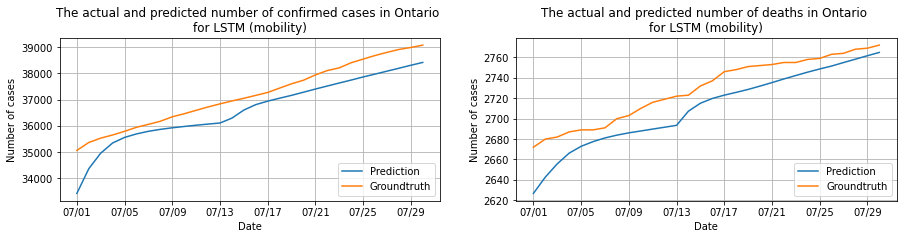

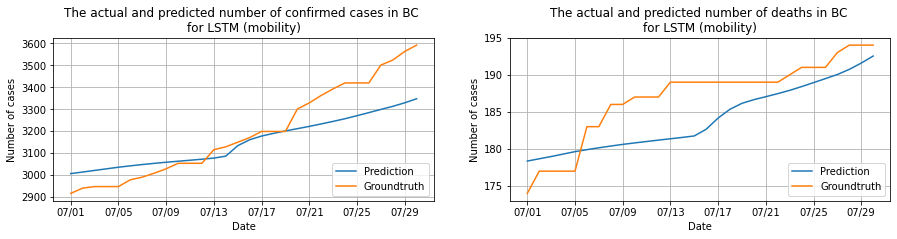

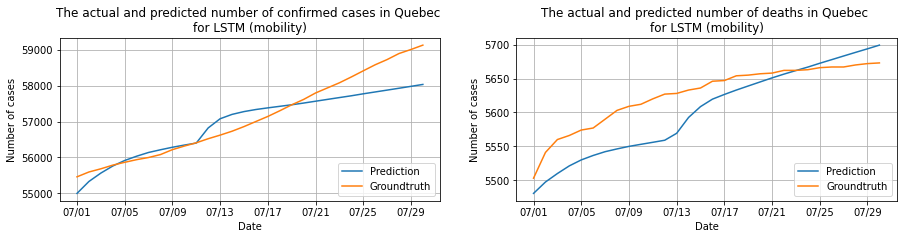

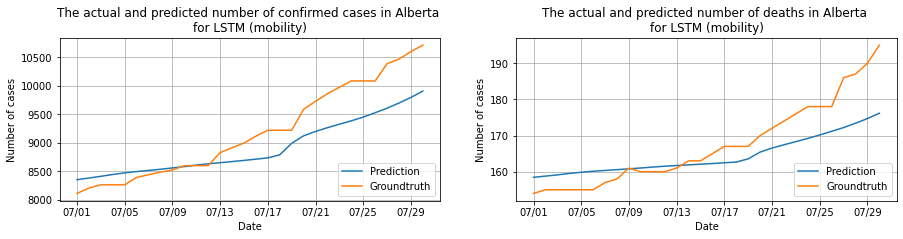

In [30]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_prediction(name+" \nfor LSTM (mobility)",label_list[p], pred_list[p])

## Linear Regression

In [31]:
def MLP_model(name,sequence_length=14, features_num = 2):

    # input layer branch
    input_layer = Input(shape=(sequence_length,features_num))
    flatten = layers.Flatten()(input_layer)
    main_dense_layer = layers.Dense(512, activation='relu')(flatten)


    #cases output branch
    dropout_c = layers.Dropout(0.2)(main_dense_layer)
    dense_c = layers.Dense(512, activation='relu')(dropout_c)
    dropout_c1 = layers.Dropout(0.2)(dense_c)
    dense_c2 = layers.Dense(64, activation='relu')(dropout_c1)
    dropout_c2 = layers.Dropout(0.2)(dense_c2)
    cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c2)

    #death output branch
    dropout_d = layers.Dropout(0.2)(main_dense_layer)
    dense_d = layers.Dense(512, activation='relu')(dropout_d)
    dropout_d1 = layers.Dropout(0.2)(dense_d)
    dense_d2 = layers.Dense(64, activation='relu')(dropout_d1)
    dropout_d2 = layers.Dropout(0.2)(dense_d2)
    deaths = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="deaths")(dropout_d2)


    model = Model([input_layer], [cases,deaths])

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath=name+'_MLP_best.h5', monitor='val_loss', save_best_only=True)]

    model.compile(loss=["mse","mse"], optimizer="adam")

    return model, callbacks

In [32]:
sequence_length = 14
input_list = []
# input with mobility
for p in range(len(provinces)):
    province_df = LSTM_input(provinces[p], sequence_length, shuffle=True)
    diction = resample(province_df)
    input_list.append(diction)

In [33]:
histories = []

for p in range(len(province_names)):
    MLP, MLP_callbacks = MLP_model(province_names[p])
    X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test = input_list[p]
    
    history = MLP.fit([X_train], [Y_confirmed_train, Y_deaths_train],
                       epochs = 50, batch_size = 10, verbose=0,
                       validation_data=([X_test],[Y_confirmed_test, Y_deaths_test]),
                       callbacks= MLP_callbacks)
    histories.append(history)


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 4.6655999904032795e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 2.799360081553459e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.

Epoch 00043: ReduceLRO

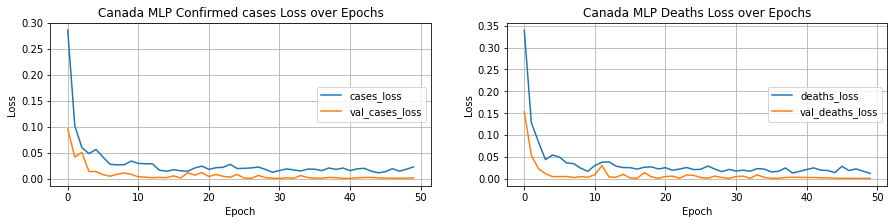

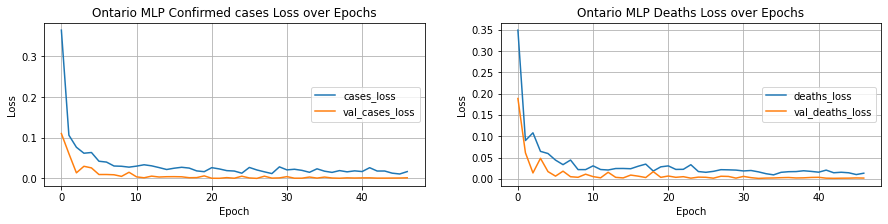

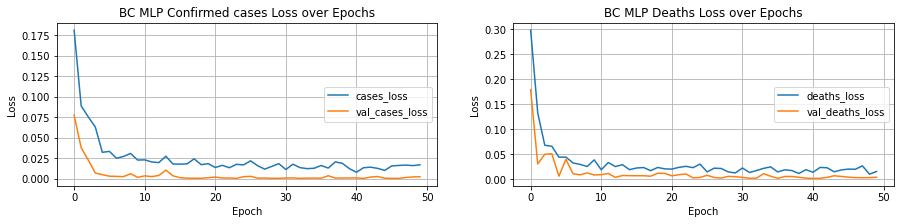

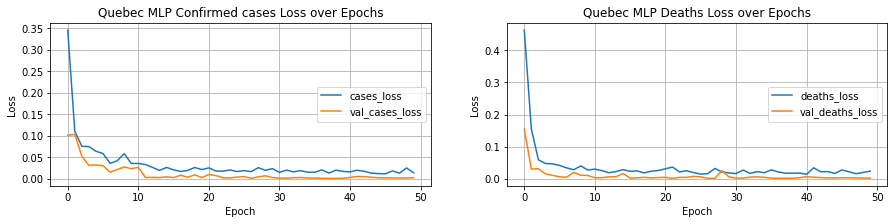

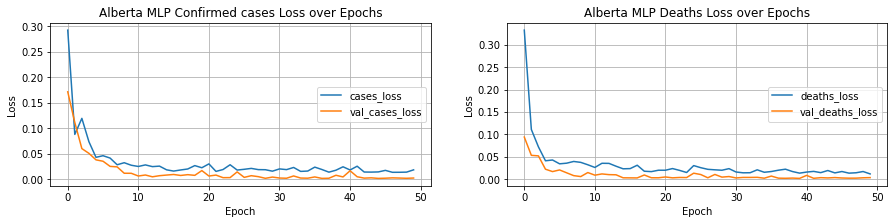

In [34]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_loss(name+" MLP", histories[p])

In [35]:
# test set preprocess
# province-wise
Canada_p = subset(train_df,"Canada","2020-06-17","2020-07-30")
Ontario_p = subset(train_df,"Ontario","2020-06-17","2020-07-30")
BC_p = subset(train_df,"British Columbia","2020-06-17","2020-07-30")
Quebec_p = subset(train_df,"Quebec","2020-06-17","2020-07-30")
Alberta_p = subset(train_df,"Alberta","2020-06-17","2020-07-30")

provinces_p = [Canada_p,Ontario_p,BC_p,Quebec_p,Alberta_p]
label_list=[]
pred_list=[]

# TEST
for p in range(len(province_names)):
    name = province_names[p]
    #s = scaler_list[p]
    scaler2 = preprocess(provinces_p[p])
    provinces_p[p] = LSTM_input(provinces_p[p], shuffle=False)
    
    x_pred, y_confirmed_pred, y_deaths_pred = LSTM_predict_set(provinces_p[p])
    MLP, MLP_callbacks = MLP_model("test")
    pred = model_predict(MLP, province_names[p]+"_MLP_best.h5", x_pred)
    print(province_names[p]+":")

    confirmed,deaths = de_scale(scaler2,pred[0],pred[1])
    real_confirmed,real_deaths = de_scale(scaler2,y_confirmed_pred,y_deaths_pred)
    
    RMSE([real_confirmed,real_deaths], [confirmed,deaths])

    label_list.append([real_confirmed,real_deaths])
    pred_list.append([confirmed,deaths])

Canada:
RMSE on test set of Confirmed cases:  1068.0424
RMSE on test set of deaths cases:  71.624306
Ontario:
RMSE on test set of Confirmed cases:  366.07883
RMSE on test set of deaths cases:  11.394277
BC:
RMSE on test set of Confirmed cases:  96.674324
RMSE on test set of deaths cases:  3.4305053
Quebec:
RMSE on test set of Confirmed cases:  390.38474
RMSE on test set of deaths cases:  51.975285
Alberta:
RMSE on test set of Confirmed cases:  300.42056
RMSE on test set of deaths cases:  5.4706235


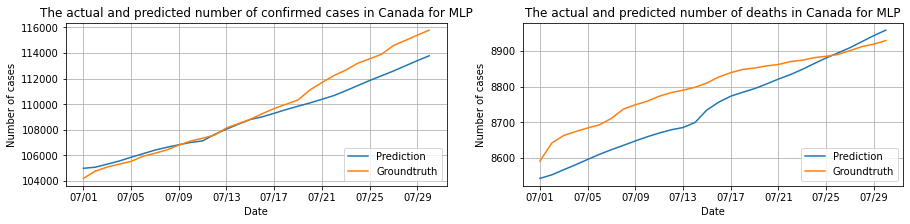

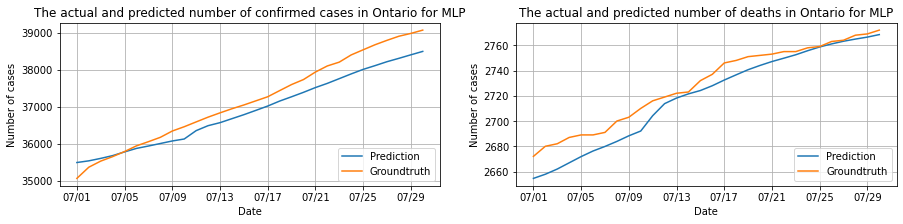

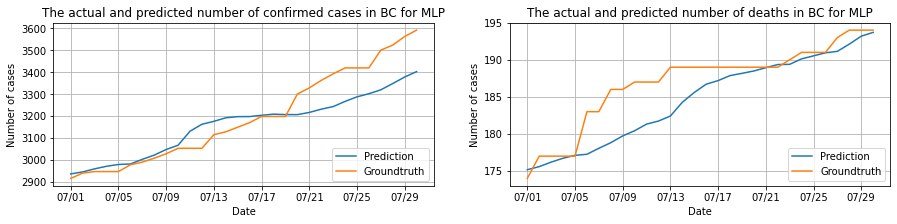

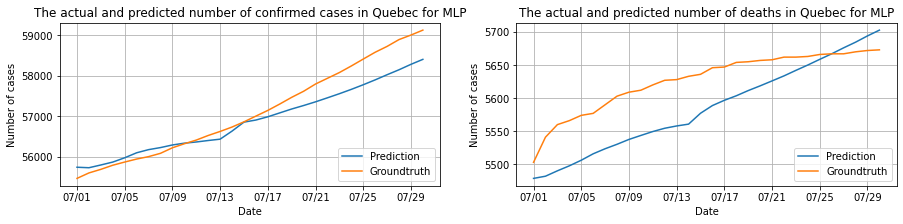

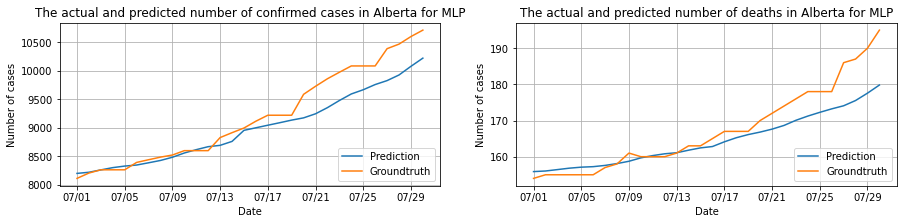

In [36]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_prediction(name+" for MLP",label_list[p], pred_list[p])

## Linear Regression with mobility

In [37]:
sequence_length = 14
input_list = []
# input with mobility
for p in range(len(provinces)):
    province_df = LSTM_input(provinces[p], sequence_length, mobility=True, shuffle=True)
    diction = resample(province_df)
    input_list.append(diction)

In [38]:
histories = []

for p in range(len(province_names)):
    MLP, MLP_callbacks = MLP_model(province_names[p]+"_mob",features_num = 3)
    X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test = input_list[p]
    
    history = MLP.fit([X_train], [Y_confirmed_train, Y_deaths_train],
                       epochs = 50, batch_size = 10, verbose=0,
                       validation_data=([X_test],[Y_confirmed_test, Y_deaths_test]),
                       callbacks= MLP_callbacks)
    histories.append(history)


Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 4.6655999904032795e-05.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 2.799360081553459e-05.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.

Epoch 00039: ReduceLRO

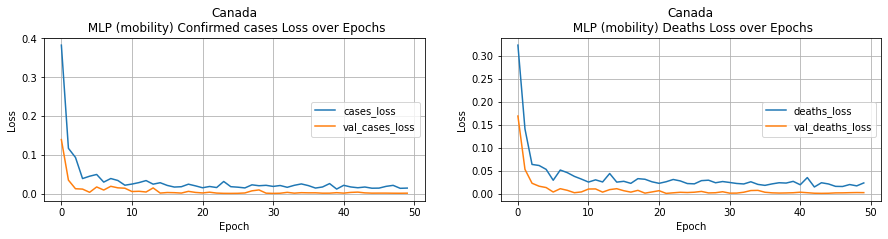

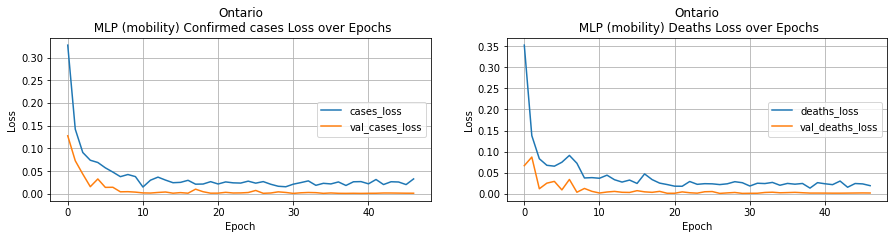

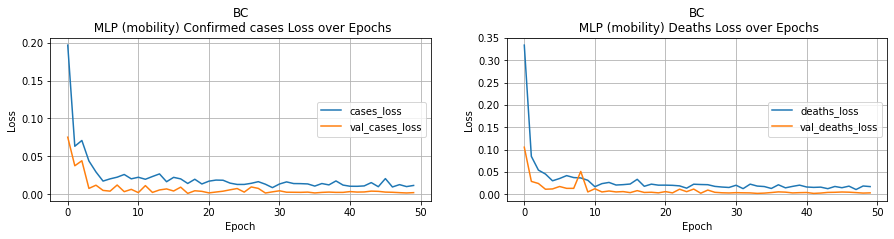

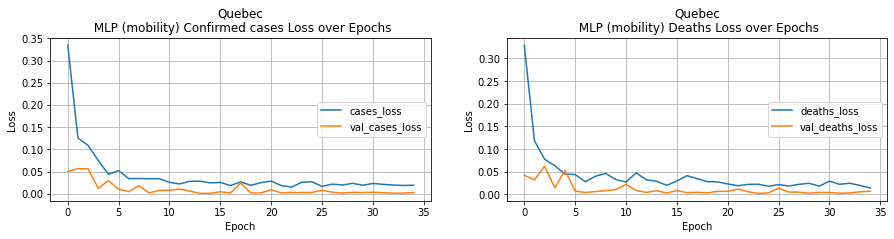

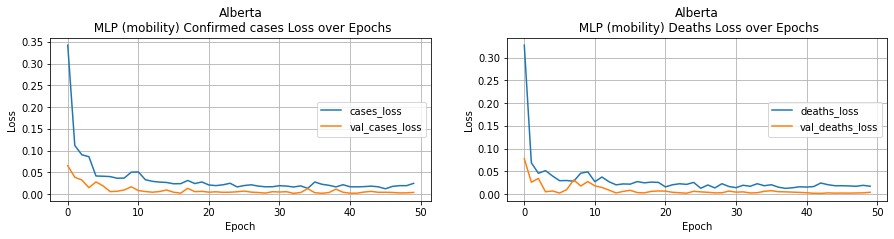

In [39]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_loss(name+"\n MLP (mobility)", histories[p])

In [40]:
# test set preprocess
# province-wise
Canada_p = subset(train_df,"Canada","2020-06-17","2020-07-30")
Ontario_p = subset(train_df,"Ontario","2020-06-17","2020-07-30")
BC_p = subset(train_df,"British Columbia","2020-06-17","2020-07-30")
Quebec_p = subset(train_df,"Quebec","2020-06-17","2020-07-30")
Alberta_p = subset(train_df,"Alberta","2020-06-17","2020-07-30")

provinces_p = [Canada_p,Ontario_p,BC_p,Quebec_p,Alberta_p]
label_list=[]
pred_list=[]

# TEST
for p in range(len(province_names)):
    name = province_names[p]
    #s = scaler_list[p]
    scaler2 = preprocess(provinces_p[p])
    provinces_p[p] = LSTM_input(provinces_p[p], mobility = True, shuffle=False)
    
    x_pred, y_confirmed_pred, y_deaths_pred = LSTM_predict_set(provinces_p[p])
    MLP, MLP_callbacks = MLP_model("test",features_num = 3)
    pred = model_predict(MLP, province_names[p]+"_mob_MLP_best.h5", x_pred)
    print(province_names[p]+":")

    confirmed,deaths = de_scale(scaler2,pred[0],pred[1])
    real_confirmed,real_deaths = de_scale(scaler2,y_confirmed_pred,y_deaths_pred)
    
    RMSE([real_confirmed,real_deaths], [confirmed,deaths])

    label_list.append([real_confirmed,real_deaths])
    pred_list.append([confirmed,deaths])

Canada:
RMSE on test set of Confirmed cases:  2150.5422
RMSE on test set of deaths cases:  89.90435
Ontario:
RMSE on test set of Confirmed cases:  899.2157
RMSE on test set of deaths cases:  31.109768
BC:
RMSE on test set of Confirmed cases:  71.51344
RMSE on test set of deaths cases:  5.507503
Quebec:
RMSE on test set of Confirmed cases:  769.8421
RMSE on test set of deaths cases:  55.849182
Alberta:
RMSE on test set of Confirmed cases:  460.2788
RMSE on test set of deaths cases:  7.068444


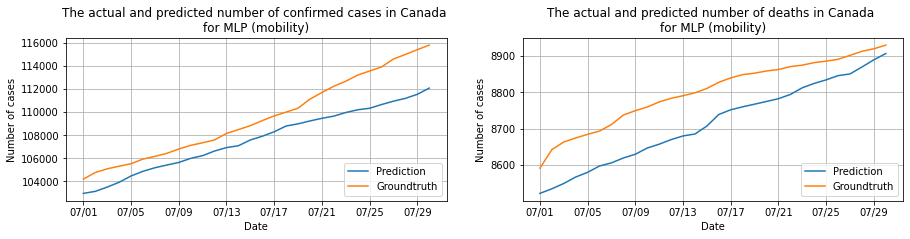

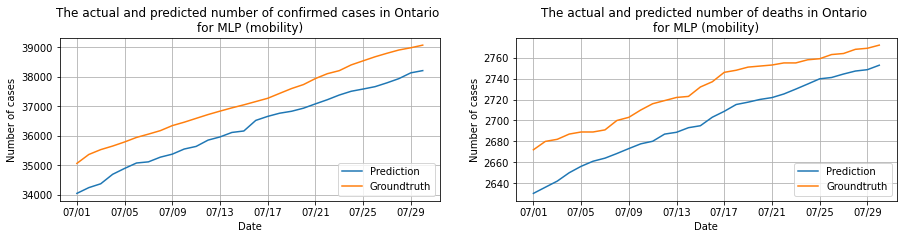

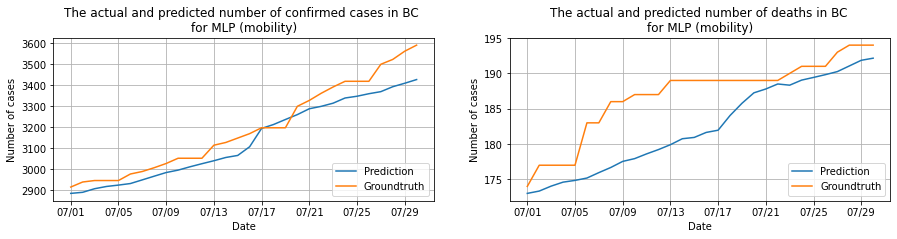

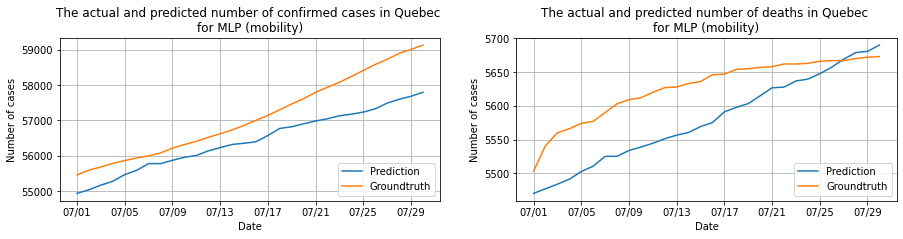

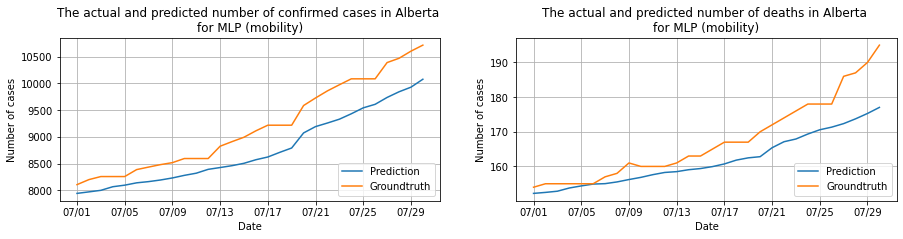

In [41]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_prediction(name+" \nfor MLP (mobility)",label_list[p], pred_list[p])

## linear regression_2

In [31]:
def MLP_model1(name):
    model = models.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(rate = 0.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(rate = 0.2))
    model.add(layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1)))

    model.compile(loss=["mse","mse"], optimizer="adam")

    return model

In [32]:
sequence_length = 14
input_list = []
# input with mobility
for p in range(len(provinces)):
    province_df = LSTM_input(provinces[p], sequence_length, shuffle=True)
    diction = resample(province_df)
    input_list.append(diction)
    

In [33]:
c_histories = []
d_histories = []
c_models = []
d_models = []
for p in range(len(province_names)):
    
    X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test = input_list[p]
    X_train_c = X_train[:,:,0]
    X_train_d = X_train[:,:,1]
    X_test_c = X_test[:,:,0]
    X_test_d = X_test[:,:,1]
    
    MLP = MLP_model1(province_names[p]+"c")
    history = MLP.fit(X_train_c, Y_confirmed_train,
                       epochs = 50, batch_size = 10, verbose=0,
                       validation_data=(X_test_c,Y_confirmed_test),
                       )
    
    c_histories.append(history)
    c_models.append(MLP)
    
    MLP = MLP_model1(province_names[p]+"d")
    history = MLP.fit(X_train_d, Y_deaths_train,
                       epochs = 50, batch_size = 10, verbose=0,
                       validation_data=(X_test_d,Y_deaths_test),
                       )
    
    d_histories.append(history)
    d_models.append(MLP)

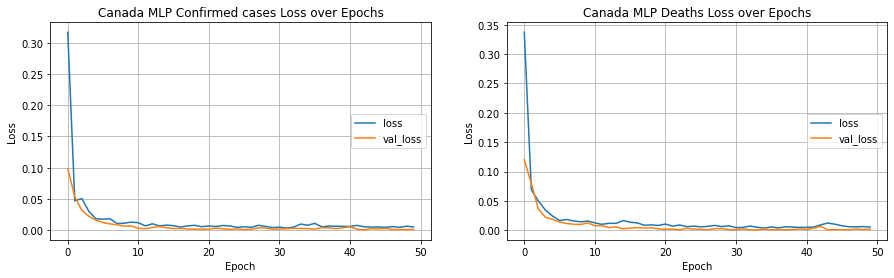

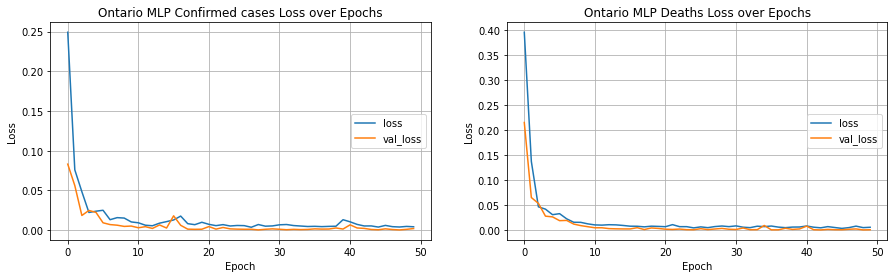

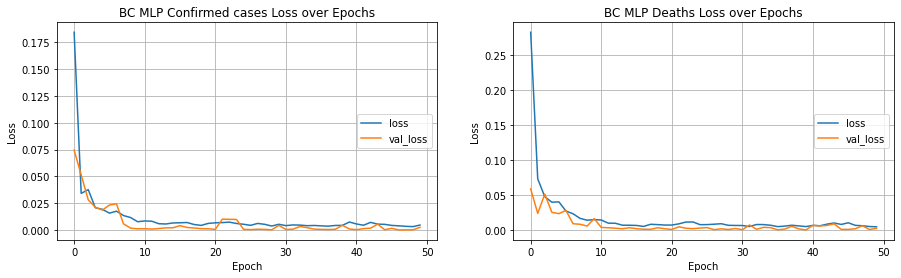

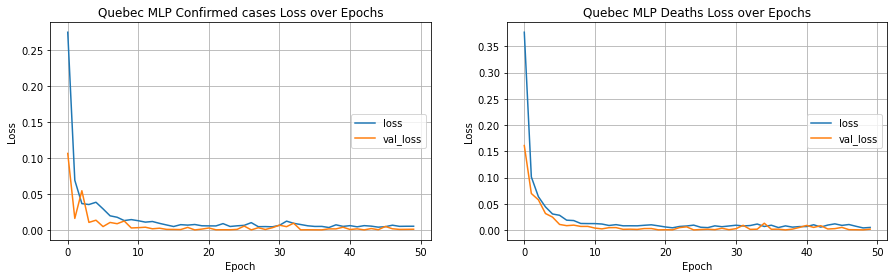

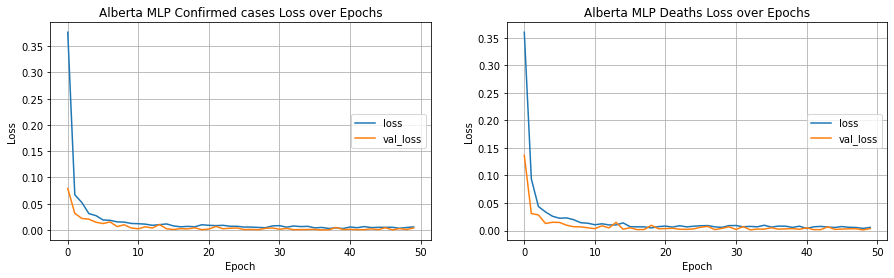

In [34]:
def plot_loss1(title, historys):
    names = [title+" Confirmed cases Loss over Epochs", title+" Deaths Loss over Epochs"]       
   
    fig, (ax1, ax2) = plt.subplots(1, 2)
    axs = [ax1,ax2]
    
    for i in range(2):
        axs[i].plot(historys[i].history["loss"], label="loss")
        axs[i].plot(historys[i].history['val_loss'], label = 'val_loss')
        axs[i].set(xlabel='Epoch', ylabel='Loss',
            title=names[i])
        axs[i].grid()
        axs[i].legend(loc='right')
    fig.set_size_inches(15, 4)
    fig.savefig(names[i]+".png")
    plt.show()
    
for p in range(len(province_names)):
    name = province_names[p]
    plot_loss1(name+" MLP", [c_histories[p],d_histories[p]])

In [35]:
# test set preprocess
# province-wise
Canada_p = subset(train_df,"Canada","2020-06-17","2020-07-30")
Ontario_p = subset(train_df,"Ontario","2020-06-17","2020-07-30")
BC_p = subset(train_df,"British Columbia","2020-06-17","2020-07-30")
Quebec_p = subset(train_df,"Quebec","2020-06-17","2020-07-30")
Alberta_p = subset(train_df,"Alberta","2020-06-17","2020-07-30")

provinces_p = [Canada_p,Ontario_p,BC_p,Quebec_p,Alberta_p]
label_list=[]
pred_list=[]

# TEST
for p in range(len(province_names)):
    name = province_names[p]
    #s = scaler_list[p]
    scaler2 = preprocess(provinces_p[p])
    provinces_p[p] = LSTM_input(provinces_p[p], shuffle=False)
    
    print(province_names[p]+":")
    
    x_pred, y_confirmed_pred, y_deaths_pred = LSTM_predict_set(provinces_p[p])

    pred_c = c_models[p].predict(x_pred[:,:,0])
    pred_d = d_models[p].predict(x_pred[:,:,1])
    
    confirmed,deaths = de_scale(scaler2,pred_c,pred_d)
    real_confirmed,real_deaths = de_scale(scaler2,y_confirmed_pred,y_deaths_pred)
    
    RMSE([real_confirmed,real_deaths], [confirmed,deaths])

    label_list.append([real_confirmed,real_deaths])
    pred_list.append([confirmed,deaths])

Canada:
RMSE on test set of Confirmed cases:  1064.2892
RMSE on test set of deaths cases:  18.510866
Ontario:
RMSE on test set of Confirmed cases:  396.26846
RMSE on test set of deaths cases:  5.4023533
BC:
RMSE on test set of Confirmed cases:  78.18875
RMSE on test set of deaths cases:  2.3170948
Quebec:
RMSE on test set of Confirmed cases:  280.2743
RMSE on test set of deaths cases:  13.20415
Alberta:
RMSE on test set of Confirmed cases:  196.42113
RMSE on test set of deaths cases:  4.7448363


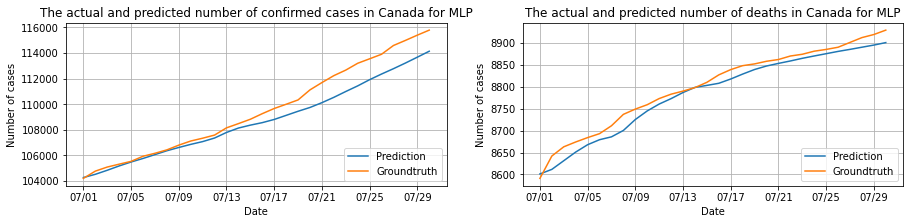

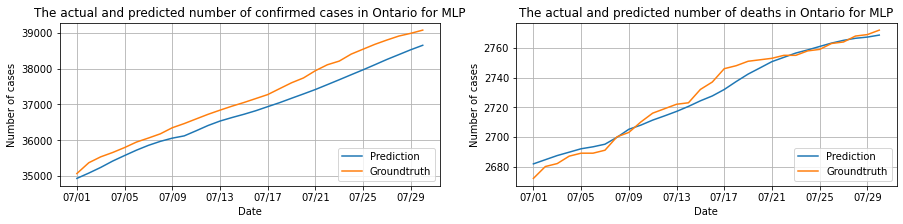

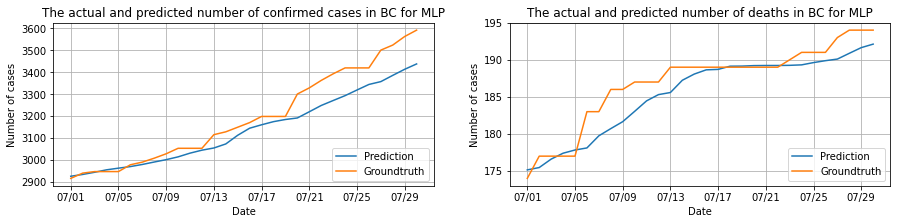

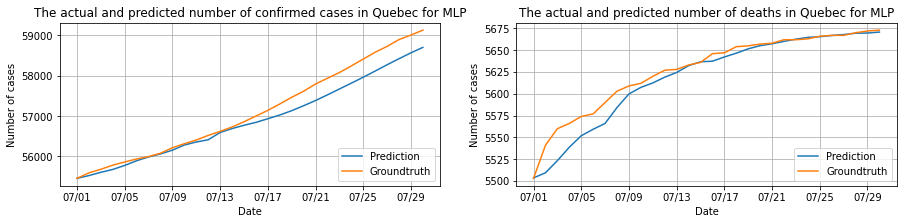

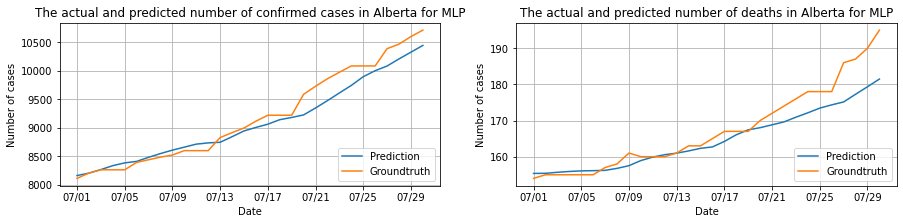

In [36]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_prediction(name+" for MLP",label_list[p], pred_list[p])

## mobility

In [37]:
sequence_length = 14
input_list = []
# input with mobility
for p in range(len(provinces)):
    province_df = LSTM_input(provinces[p], sequence_length, mobility=True, shuffle=True)
    diction = resample(province_df)
    input_list.append(diction)

In [38]:
input_list[0][0].shape

(78, 14, 3)

In [39]:
c_histories = []
d_histories = []
c_models = []
d_models = []
for p in range(len(province_names)):
    
    X_train, Y_confirmed_train, Y_deaths_train, X_test, Y_confirmed_test, Y_deaths_test = input_list[p]
    X_train_c = X_train[:,:,[0,2]]
    X_train_d = X_train[:,:,[1,2]]
    X_test_c = X_test[:,:,[0,2]]
    X_test_d = X_test[:,:,[1,2]]
    
    MLP = MLP_model1(province_names[p]+"c")
    history = MLP.fit(X_train_c, Y_confirmed_train,
                       epochs = 50, batch_size = 10, verbose=0,
                       validation_data=(X_test_c,Y_confirmed_test),
                       )
    
    c_histories.append(history)
    c_models.append(MLP)
    
    MLP = MLP_model1(province_names[p]+"d")
    history = MLP.fit(X_train_d, Y_deaths_train,
                       epochs = 50, batch_size = 10, verbose=0,
                       validation_data=(X_test_d,Y_deaths_test),
                       )
    
    d_histories.append(history)
    d_models.append(MLP)

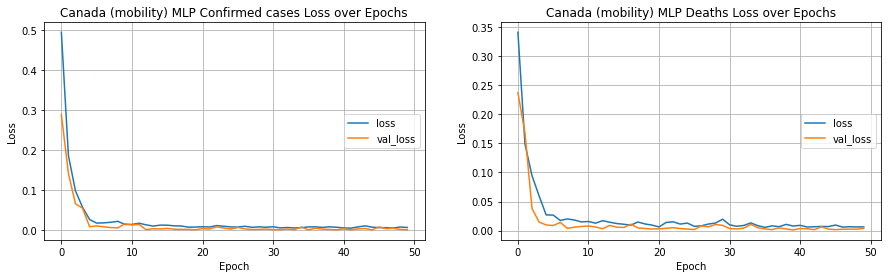

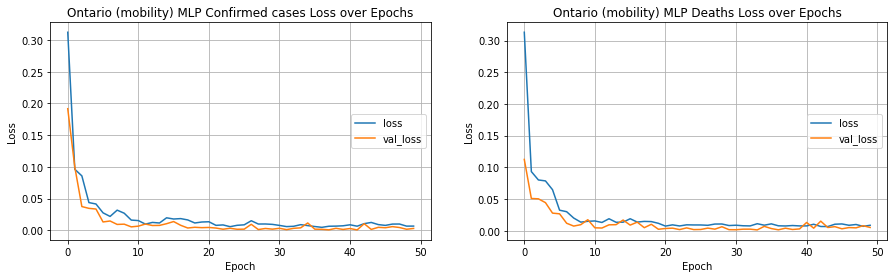

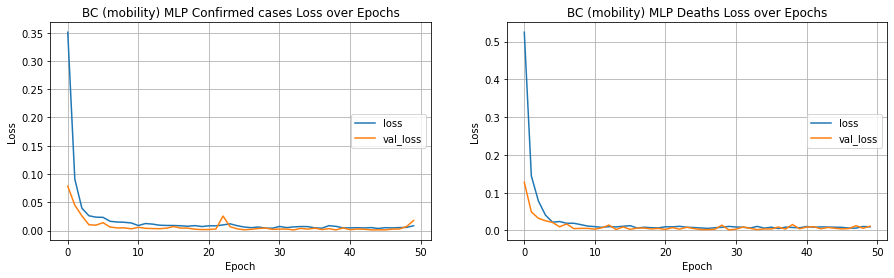

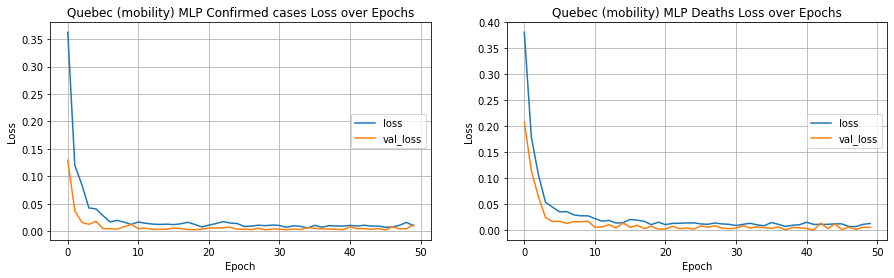

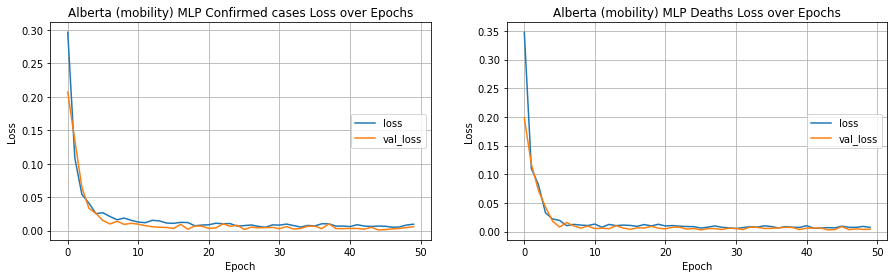

In [40]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_loss1(name+" (mobility) MLP", [c_histories[p],d_histories[p]])

In [41]:
# test set preprocess
# province-wise
Canada_p = subset(train_df,"Canada","2020-06-17","2020-07-30")
Ontario_p = subset(train_df,"Ontario","2020-06-17","2020-07-30")
BC_p = subset(train_df,"British Columbia","2020-06-17","2020-07-30")
Quebec_p = subset(train_df,"Quebec","2020-06-17","2020-07-30")
Alberta_p = subset(train_df,"Alberta","2020-06-17","2020-07-30")

provinces_p = [Canada_p,Ontario_p,BC_p,Quebec_p,Alberta_p]
label_list=[]
pred_list=[]

# TEST
for p in range(len(province_names)):
    name = province_names[p]
    #s = scaler_list[p]
    scaler2 = preprocess(provinces_p[p])
    provinces_p[p] = LSTM_input(provinces_p[p], mobility=True, shuffle=False)
    
    print(province_names[p]+":")
    
    x_pred, y_confirmed_pred, y_deaths_pred = LSTM_predict_set(provinces_p[p])

    pred_c = c_models[p].predict(x_pred[:,:,[0,2]])
    pred_d = d_models[p].predict(x_pred[:,:,[1,2]])
    
    confirmed,deaths = de_scale(scaler2,pred_c,pred_d)
    real_confirmed,real_deaths = de_scale(scaler2,y_confirmed_pred,y_deaths_pred)
    
    RMSE([real_confirmed,real_deaths], [confirmed,deaths])

    label_list.append([real_confirmed,real_deaths])
    pred_list.append([confirmed,deaths])

Canada:
RMSE on test set of Confirmed cases:  2432.4736
RMSE on test set of deaths cases:  81.05752
Ontario:
RMSE on test set of Confirmed cases:  943.7504
RMSE on test set of deaths cases:  27.21851
BC:
RMSE on test set of Confirmed cases:  147.23384
RMSE on test set of deaths cases:  4.1664042
Quebec:
RMSE on test set of Confirmed cases:  779.5768
RMSE on test set of deaths cases:  37.036755
Alberta:
RMSE on test set of Confirmed cases:  405.56235
RMSE on test set of deaths cases:  7.4626584


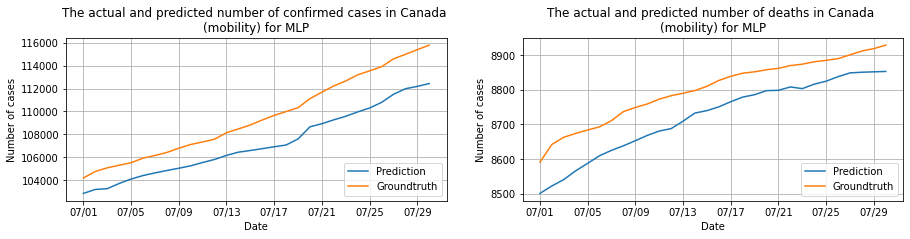

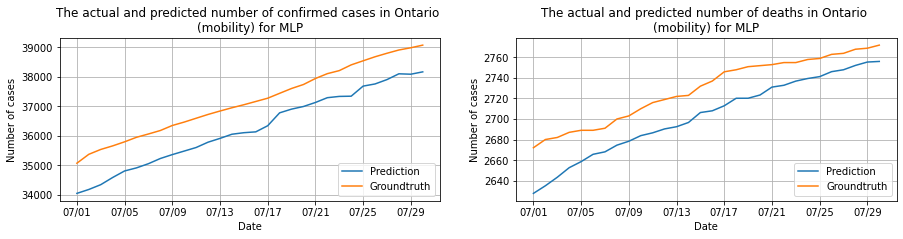

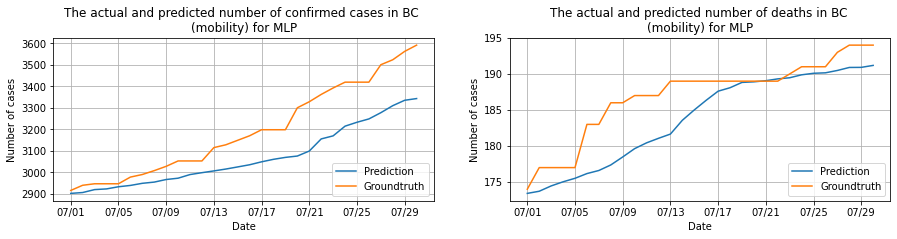

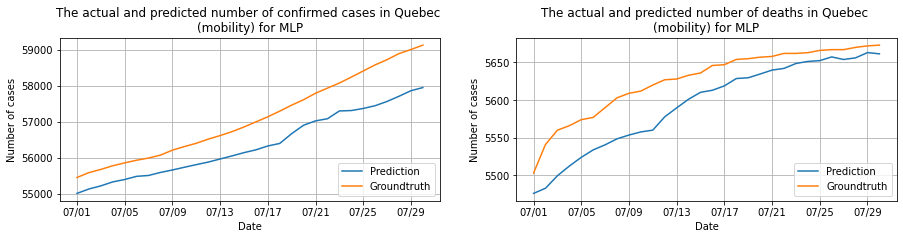

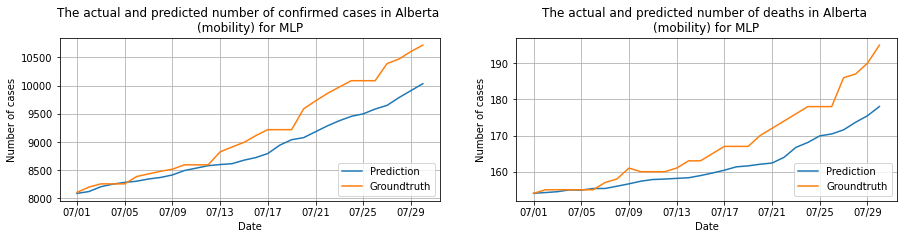

In [42]:
for p in range(len(province_names)):
    name = province_names[p]
    plot_prediction(name+" \n(mobility) for MLP",label_list[p], pred_list[p])

## SIR regression

In [ ]:
# SIR
# latent in confirmed cases and deaths
# imigration from other infected areas
#gamma = (gamma1*old_ratio+gamma2*(1-old_ratio))
#alpha = (alpha1*old_ratio+alpha2*(1-old_ratio))
# assume S is constant
dS = -beta*S*I/N
dI = sigma*beta*S*I/N-gamma*I-alpha*I
dR = gamma*I

pred_S+=dS
pred_I+=dI
pred_R+=dR

loss = (np.log(pred_I)-np.log(I))^2+(np.log(pred_R)-np.log(R))^2


mlp = models.Sequential()
mlp.add(layers.Dense(10, activation='relu'))
mlp.add(layers.Dense(10, activation='relu'))
mlp.add(layers.Dense(1))

